In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/btp2/Augmented",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 2640 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names
class_name

['Aedes Aegypti', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

In [ ]:
len(dataset)

83

(32, 256, 256, 3)
[0 0 1 2 0 0 0 2 0 0 0 0 0 0 0 1 0 0 2 1 2 2 0 2 1 1 0 0 2 2 2 2]


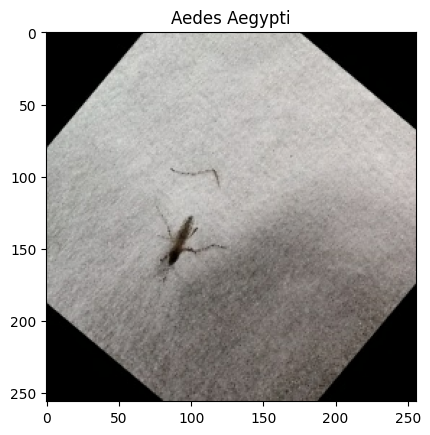

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_name[label_batch[0]])
  # plt.axis

In [ ]:
train_size = 0.8
len(dataset)*train_size

66.4

In [ ]:
train_ds = dataset.take(66)
len(train_ds)

66

In [ ]:
test_ds = dataset.skip(66)
len(test_ds)

17

In [ ]:
val_size = 0.1
len(dataset)*val_size

8.3

In [ ]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [ ]:
test_ds = test_ds.skip(8)
len(test_ds)

9

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

66

In [ ]:
len(val_ds)

8

In [ ]:
len(test_ds)

9

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
IMAGE_SIZE = 256

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Apply random flipping
    layers.RandomRotation(0.2)                    # Apply random rotation
])


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
n_classes = 3
EPOCHS=50

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Model 1: CNN**

In [ ]:
# Define input shape excluding batch size
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Build the model
model = models.Sequential([
    layers.Input(shape=input_shape),  # Explicitly define input shape
    resize_and_rescale,               # Add preprocessing layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 391s 485ms/step - accuracy: 0.4271 - loss: 1.0674 - val_accuracy: 0.4844 - val_loss: 1.0519
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.4456 - loss: 1.0599 - val_accuracy: 0.4844 - val_loss: 1.0367
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.4679 - loss: 1.0450 - val_accuracy: 0.4844 - val_loss: 1.0423
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.4737 - loss: 1.0441 - val_accuracy: 0.4844 - val_loss: 1.0588
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 0.4641 - loss: 1.0549 - val_accuracy: 0.4844 - val_loss: 1.0395
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.4488 - loss: 1.0603 - val_accuracy: 0.4844 - val_loss: 1.0332
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - accuracy: 0.4720 - loss: 1.0390 - val_accuracy: 0.4844 - val_loss: 1.0329
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.4602 - loss: 1.0479 - val_acc

In [ ]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9259 - loss: 0.2016


In [ ]:
scores

[0.1742350310087204, 0.9409722089767456]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 66}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

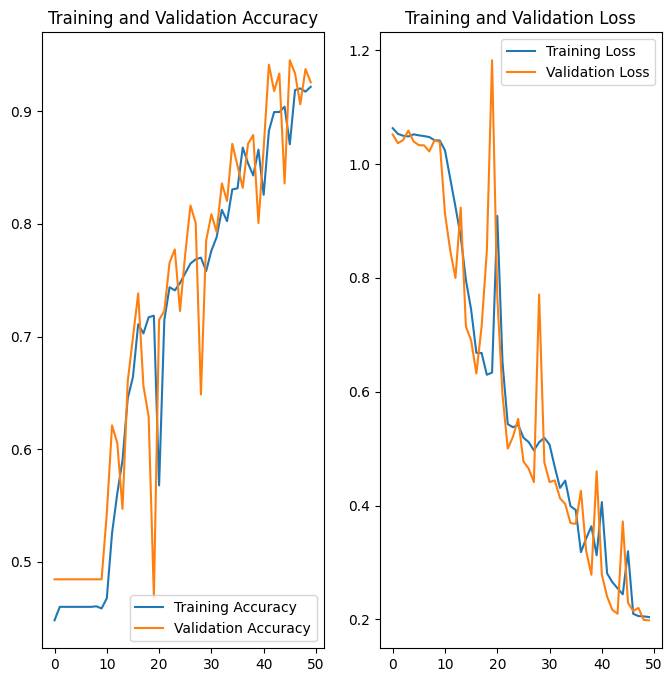

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Culex Quinquefasciatus
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
predicted label: Culex Quinquefasciatus


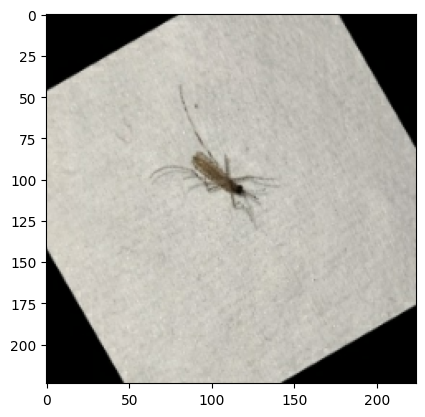

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


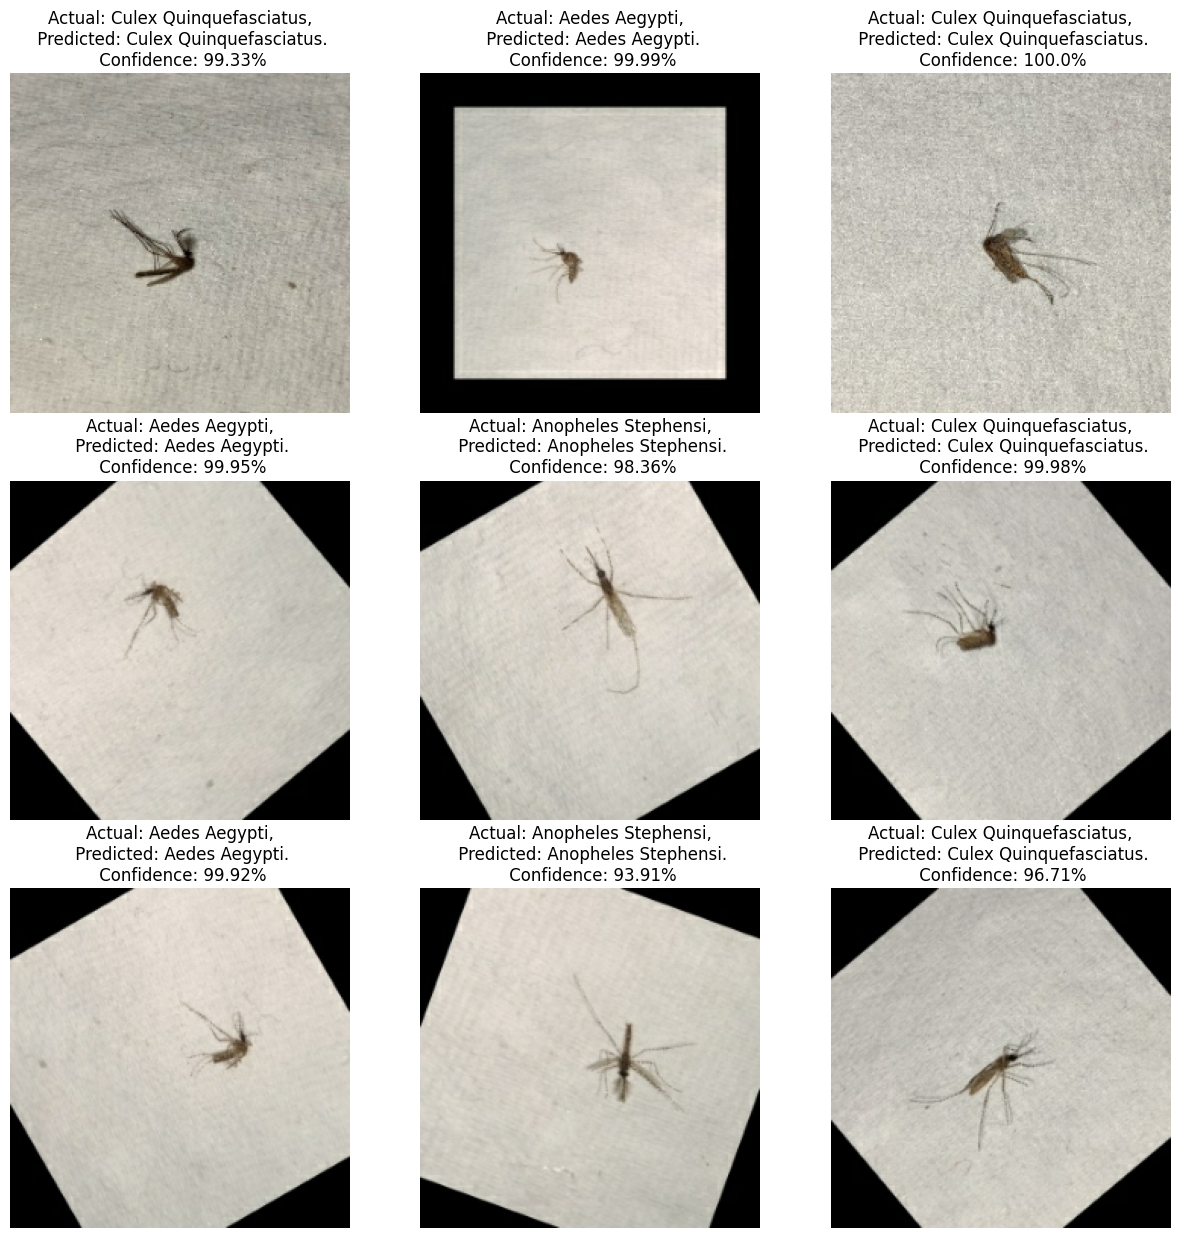

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model.save("/content/drive/MyDrive/btp_/models/C_augumented.h5")


**Model 2: trasfer learning ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze the base model
base_model.trainable = False

# Build the model
model_2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_2.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,719,043 (90.48 MB)

 Trainable params: 131,331 (513.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 531s 584ms/step - accuracy: 0.6411 - loss: 0.8825 - val_accuracy: 0.8633 - val_loss: 0.3716
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.8583 - loss: 0.3694 - val_accuracy: 0.8945 - val_loss: 0.3251
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9094 - loss: 0.2351 - val_accuracy: 0.8867 - val_loss: 0.3110
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.9444 - loss: 0.1673 - val_accuracy: 0.9062 - val_loss: 0.2512
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 373ms/step - accuracy: 0.9430 - loss: 0.1571 - val_accuracy: 0.9219 - val_loss: 0.2424
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9604 - loss: 0.1234 - val_accuracy: 0.9297 - val_loss: 0.1792
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.9569 - loss: 0.1179 - val_accuracy: 0.8945 - val_loss: 0.2373
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 372ms/step - accuracy: 0.9672 - loss: 0.0989 - val_acc

In [ ]:
scores = model_2.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.9738 - loss: 0.0677


In [ ]:
import os
model_2.save("/content/drive/MyDrive/btp_/models/T_augumented.h5")
